In [60]:
import pandas as pd
data = pd.read_excel('/content/spam2.xlsx')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [61]:
data = data[['v1','v2']].drop_duplicates()
data = data.rename({'v1':'label','v2':'email'},axis=1)
data.head()

,label,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [62]:
data['label'] = data['label'].map({'spam': 1, 'ham': 0}) # Encoding Target variable to 0 and 1

In [63]:
# Initialize TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
data['email'] = data['email'].astype(str)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['email'])


In [64]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['label'], test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)


Accuracy: 97.39%


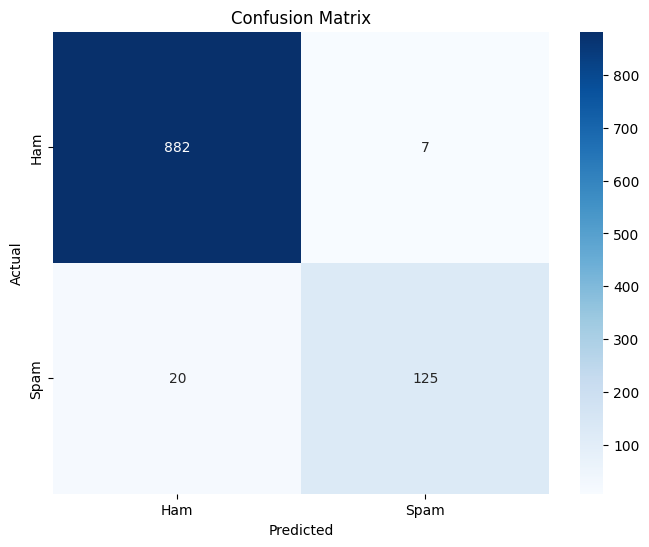

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
######################################################################### Adding Transformer's BERT uncased model ####################################################################

In [7]:
pip install transformers torch

In [66]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

# Load a pretrained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

def extract_keywords(email, importance_threshold=0.5, top_n=10):
    try:
      # Tokenize the email and get input IDs and attention mask
      inputs = tokenizer(email, return_tensors="pt", truncation=True, padding=True)

      # Get model outputs (embeddings for each token)
      with torch.no_grad():
          outputs = model(**inputs)

      # Get token embeddings from the last hidden layer
      token_embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (seq_len, hidden_size)

      # Get token IDs and convert them back to words (tokens)
      tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))

      # Calculate the norm of each token's embedding to determine importance
      token_importances = torch.norm(token_embeddings, dim=1).cpu().numpy()  # Norm of each token's embedding

      # Get the most important tokens based on their importance scores
      important_tokens = []
      for token, importance in zip(tokens, token_importances):
          if importance > importance_threshold and token not in tokenizer.all_special_tokens:
              important_tokens.append((token, importance))

      # If fewer than top_n important tokens, use all; otherwise, sort by importance and get top_n
      important_tokens = sorted(important_tokens, key=lambda x: x[1], reverse=True)[:top_n]

      # Extract just the token strings for the output
      keywords = [token[0] for token in important_tokens]

      # Return the important tokens as a string and their importance scores


      return ' '.join(keywords)# , important_tokens  # Return both the keywords and their importance scores

    except:
      return None


# Apply the function to extract keywords for each email
tqdm.pandas()
data['keywords'] = data['email'].progress_apply(extract_keywords)

data.head()


100%|██████████| 5169/5169 [14:46<00:00,  5.83it/s]


,label,email,keywords
0,0,"Go until jurong point, crazy.. Available only ...",. . . . . bug . . ci .
1,0,Ok lar... Joking wif u oni...,. . . . . . wi ##f on ##i
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,cup fa st may 08 final & 21st ' ##100
3,0,U dun say so early hor... U c already then say...,. . . u ho . u . ##r dun
4,0,"Nah I don't think he goes to usf, he lives aro...","i don nah , though around think t here us"


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
data['combined_set1'] = data['email'] + ' ' + data['keywords']  # Adding vocabulary to existing tf-idf
data['combined_set1'] = data['combined_set1'].astype(str)
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # or any other parameters
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_set1'])


In [68]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['label'], test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)


Accuracy: 98.16%


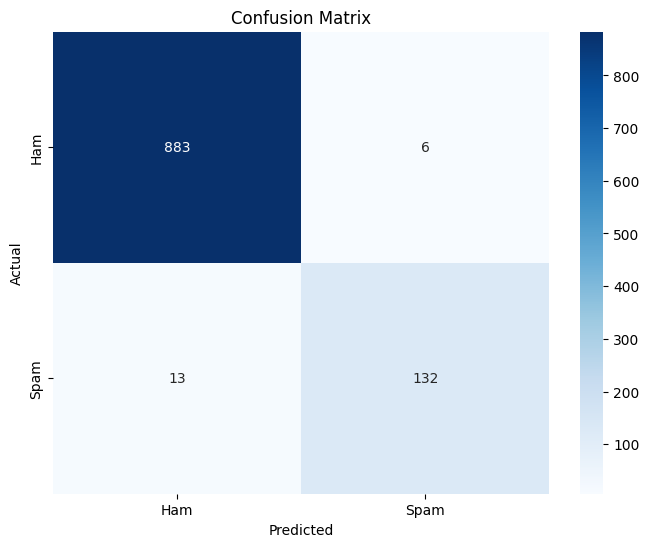

In [69]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
###################################################################### Adding Keybert ###################################################################################################

In [70]:
from keybert import KeyBERT

# Initialize KeyBERT model
def keybert_extractor(email):
  try:
    kw_model = KeyBERT()



    # Extract keywords
    keywords = kw_model.extract_keywords(email, top_n=10)

    # Print extracted keywords
    return keywords
  except:
    return None
tqdm.pandas()
data['keywords2'] = data['email'].progress_apply(keybert_extractor)
data.head()

100%|██████████| 5169/5169 [1:04:44<00:00,  1.33it/s]


,label,email,keywords,combined_set1,keywords2
0,0,"Go until jurong point, crazy.. Available only ...",. . . . . bug . . ci .,"Go until jurong point, crazy.. Available only ...","[(buffet, 0.4196), (amore, 0.4132), (la, 0.342..."
1,0,Ok lar... Joking wif u oni...,. . . . . . wi ##f on ##i,Ok lar... Joking wif u oni... . . . . . . wi #...,"[(joking, 0.5326), (oni, 0.434), (wif, 0.4236)..."
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,cup fa st may 08 final & 21st ' ##100,Free entry in 2 a wkly comp to win FA Cup fina...,"[(entry, 0.5009), (txt, 0.377), (tkts, 0.3439)..."
3,0,U dun say so early hor... U c already then say...,. . . u ho . u . ##r dun,U dun say so early hor... U c already then say...,"[(early, 0.5722), (say, 0.4188), (hor, 0.3502)..."
4,0,"Nah I don't think he goes to usf, he lives aro...","i don nah , though around think t here us","Nah I don't think he goes to usf, he lives aro...","[(usf, 0.5949), (nah, 0.2268), (goes, 0.1769),..."


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
data['keywords2'] = data['keywords2'].astype(str)
data['combined_set2'] = data['combined_set1'] + ' ' + data['keywords2'] # Adding more vocabulary in tf-idf
data['combined_set2'] = data['combined_set2'].astype(str)
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # or any other parameters
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_set2'])


In [73]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data['label'], test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)


Accuracy: 98.45%


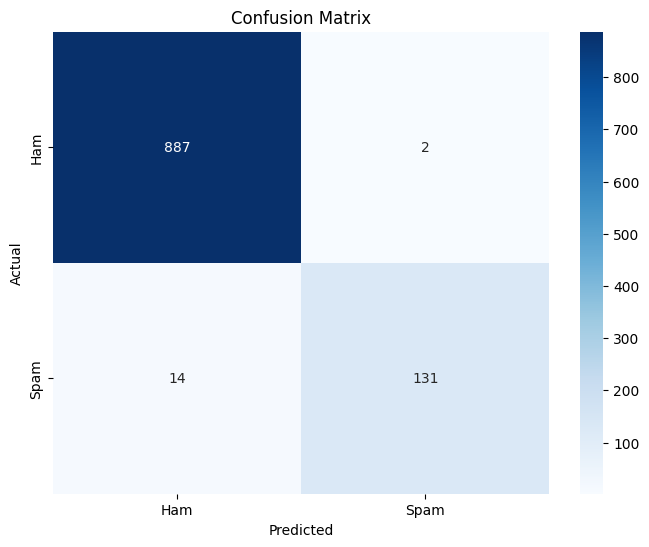

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()